In [247]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter, defaultdict
import math
from matplotlib import pyplot as plt
import tqdm

In [248]:
def load_data(in_file, max_example=None, relabeling=True):
    """
        load CNN / Daily Mail data from {train | dev | test}.txt
        relabeling: relabel the entities by their first occurence if it is True.
    """

    documents = []
    questions = []
    answers = []
    num_examples = 0
    with open(in_file, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            question = line.strip().lower()
            answer = f.readline().strip()
            document = f.readline().strip().lower()

            if relabeling:
                q_words = question.split(' ')
                d_words = document.split(' ')
                assert answer in d_words

                entity_dict = {}
                entity_id = 0
                for word in d_words + q_words:
                    if (word.startswith('@entity')) and (word not in entity_dict):
                        entity_dict[word] = '@entity' + str(entity_id)
                        entity_id += 1

                q_words = [entity_dict[w] if w in entity_dict else w for w in q_words]
                d_words = [entity_dict[w] if w in entity_dict else w for w in d_words]
                answer = entity_dict[answer]

                question = ' '.join(q_words)
                document = ' '.join(d_words)

            questions.append(question)
            answers.append(answer)
            documents.append(document)
            num_examples += 1

            f.readline()
            if (max_example is not None) and (num_examples >= max_example):
                break
                
    print('#Examples: %d' % len(documents))
    return (documents, questions, answers)

In [249]:
fin_train = 'data/cnn/train.txt'
fin_dev = 'data/cnn/dev.txt'

print('*' * 10 + ' Train Loading')
train_d, train_q, train_a = load_data(fin_train, 5000, relabeling=True)
print('*' * 10 + ' Dev Loading')
dev_d, dev_q, dev_a = load_data(fin_dev, 5000, relabeling=True)

********** Train Loading
#Examples: 5000
********** Dev Loading
#Examples: 3924


In [250]:
print(train_d[0])
print(train_q[0])
print(train_a[0])

days after two @entity0 journalists were killed in northern @entity1 , authorities rounded up dozens of suspects and a group linked to @entity2 claimed responsibility for the deaths . at least 30 suspects were seized in desert camps near the town of @entity3 and taken to the local @entity0 army base for questioning , three officials in @entity1 said . the officials did not want to be named because they are not authorized to talk to the media . @entity4 ( @entity4 ) has allegedly claimed responsibility for the killings , according to @entity5 news agency in @entity6 . @entity4 operates in northern @entity7 and the group 's statements have shown up before on the @entity8 outlet . @entity9 journalists @entity10 and @entity11 were abducted in front of the home of a member of the @entity12 rebels ' @entity13 of a @entity14 on saturday , @entity9 reported . they were found dead the same day . their bodies arrived in @entity15 on tuesday . @entity3 was one of the strongholds of the @entity16 

In [251]:
def build_dict(sentences, max_words=50000):
    """
        Build a dictionary for the words in `sentences`.
        Only the max_words ones are kept and the remaining will be mapped to <UNK>.
    """
    word_count = Counter()
    for sent in sentences:
        for w in sent.split(' '):
            word_count[w] += 1

    ls = word_count.most_common(max_words)
    print('#Words: %d -> %d' % (len(word_count), len(ls)))
    for key in ls[:5]:
        print(key)
    print('...')
    for key in ls[-5:]:
        print(key)

    # leave 0 to UNK
    # leave 1 to delimiter |||
    return {w[0]: index + 2 for (index, w) in enumerate(ls)}

In [252]:
print('Build dictionary..')
word_dict = build_dict(train_d + train_q)
entity_markers = list(set([w for w in word_dict.keys()
                          if w.startswith('@entity')] + train_a))
entity_markers = ['<unk_entity>'] + entity_markers
entity_dict = {w: index for (index, w) in enumerate(entity_markers)}
print('Entity markers: %d' % len(entity_dict))
num_labels = len(entity_dict)

Build dictionary..
#Words: 41749 -> 41749
('the', 202789)
(',', 181868)
('.', 155763)
('to', 95559)
('"', 92261)
...
('columnists', 1)
('anti-capitalist', 1)
('67.3', 1)
('footballs', 1)
('non-tv', 1)
Entity markers: 528


In [253]:
def gen_embeddings(word_dict, dim, in_file=None):
    """
        Generate an initial embedding matrix for `word_dict`.
        If an embedding file is not given or a word is not in the embedding file,
        a randomly initialized vector will be used.
    """

    num_words = len(word_dict) + 2
    embeddings = np.random.uniform(size=(num_words, dim))
    print('Embeddings: %d x %d' % (num_words, dim))

    if in_file is not None:
        print('Loading embedding file: %s' % in_file)
        pre_trained = 0
        for line in open(in_file).readlines():
            sp = line.split()
            assert len(sp) == dim + 1 # word + embeddings ..
            if sp[0] in word_dict:
                pre_trained += 1
                embeddings[word_dict[sp[0]]] = [float(x) for x in sp[1:]]
        print('Pre-trained: %d (%.2f%%)' %
              (pre_trained, pre_trained * 100.0 / num_words))
    return embeddings

In [254]:
embedding_size = 50
embeddings = gen_embeddings(word_dict, embedding_size, 'data/glove.6B/glove.6B.{}d.txt'.format(embedding_size))

Embeddings: 41751 x 50
Loading embedding file: data/glove.6B/glove.6B.50d.txt
Pre-trained: 38934 (93.25%)


In [255]:
class Net(nn.Module):

    def __init__(self, word_dict, entity_dict, embeddings, embedding_dim, hidden_dim):
        super(Net, self).__init__()
        
        self.word_dict = word_dict
        self.embeddings = embeddings
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim // 2 * 2

        self.d_gru = nn.GRU(embedding_dim, self.hidden_dim // 2,
                            num_layers=1, bidirectional=True)
        self.q_gru = nn.GRU(embedding_dim, self.hidden_dim // 2,
                            num_layers=1, bidirectional=True)
        
        self.entity_dict = entity_dict
        self.entity_dim = len(entity_dict)
        self.lin = nn.Linear(self.hidden_dim, self.entity_dim)
            
    def init_hidden(self):
        # Variable(num_layers*num_directions, minibatch_size, hidden_dim)
        return Variable(torch.randn(2, 1, self.hidden_dim // 2))
    
    def forward(self, d, q):
        d_words = d.split()
        q_words = q.split()
        d_idx = [self.word_dict[dw] for dw in d_words]
        q_idx = [self.word_dict[qw] for qw in q_words]
        d_emb = [self.embeddings[i] for i in d_idx] # !bug: max_words not in word_dict
        q_emb = [self.embeddings[i] for i in q_idx]
        d_emb = Variable(torch.FloatTensor(d_emb), requires_grad=True)
        q_emb = Variable(torch.FloatTensor(q_emb), requires_grad=True)
        
        d_hidden = self.init_hidden()
        q_hidden = self.init_hidden()
        d_gru_out, d_hidden = self.d_gru(d_emb.view(len(d_words), 1, -1), # (seq_len, batch, input_size)
                                         d_hidden)
        q_gru_out, q_hidden = self.q_gru(q_emb.view(len(q_words), 1, -1), # (seq_len, batch, input_size)
                                         q_hidden)
        q_gru_out_mean = q_gru_out.view(len(q_words), -1).mean(dim=0)
        
        d_gru_out = d_gru_out.view(len(d_words), self.hidden_dim)
        q_gru_out = q_gru_out.view(len(q_words), self.hidden_dim)
        #sim = torch.mm(d_gru_out, q_hidden.view(self.hidden_dim,1))
        sim = torch.mm(d_gru_out, q_gru_out_mean.view(self.hidden_dim,1))
        o = torch.sum(d_gru_out * sim, dim=0)
        
        ol = self.lin(o)
        dummy = Variable(torch.FloatTensor([float('-inf')] * self.entity_dim))
        ol2 = torch.cat((ol.view(-1,1), dummy.view(-1,1)), dim=1)
        d_ent_idx = set(list(filter(lambda x: x, 
                                [self.entity_dict.get(dw, None)
                                 for dw in d_words])))
        o_idx = [0 if i in d_ent_idx else 1 for i in range(self.entity_dim)]
        o = ol2.gather(1, Variable(torch.Tensor(o_idx).long().view(-1,1)))
        
        return F.log_softmax(o, dim=0)

COUNT 0, Loss: 67.60638427734375
COUNT 50, Loss: 45.201202392578125
COUNT 100, Loss: 0.0017576389946043491
COUNT 150, Loss: 0.0006463822210207582
COUNT 200, Loss: 28.790645599365234
COUNT 250, Loss: 43.213584899902344
COUNT 300, Loss: 19.074033737182617
COUNT 350, Loss: 2.2387421131134033
COUNT 400, Loss: 4.356839656829834
COUNT 450, Loss: 10.876694679260254
COUNT 500, Loss: 10.218324661254883
COUNT 550, Loss: 0.3841647207736969
COUNT 600, Loss: 4.77092981338501
COUNT 650, Loss: 24.157638549804688
COUNT 700, Loss: 7.004776477813721
COUNT 750, Loss: 6.537790298461914
COUNT 800, Loss: 137.57687377929688
COUNT 850, Loss: 2.1584861278533936
COUNT 900, Loss: 97.4387435913086
COUNT 950, Loss: 3.503525733947754
COUNT 1000, Loss: 16.61606788635254
COUNT 1050, Loss: 3.428699493408203
COUNT 1100, Loss: 8.48979663848877
COUNT 1150, Loss: 7.652898788452148
COUNT 1200, Loss: 4.13846492767334
COUNT 1250, Loss: 1.051987648010254
COUNT 1300, Loss: 9.055276870727539
COUNT 1350, Loss: 6.819807529449463


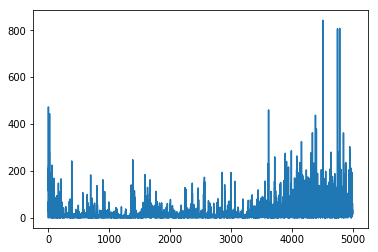

In [256]:
torch.manual_seed(42)

hidden_dim = 5
net = Net(word_dict, entity_dict, embeddings, embedding_size, hidden_dim)
loss_function = nn.NLLLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.05)
optimizer = optim.Adam(net.parameters(), lr=0.05)

losses = list()
cnt = 0
for i,d,q,a in zip(range(len(train_a)), train_d, train_q, train_a): # !test
    net.zero_grad()
    log_probs = net(d, q)
    target = Variable(torch.LongTensor([entity_dict[a]]))
    loss = loss_function(log_probs.view(1,-1), target)
    losses.append(loss.data.numpy().tolist()[0])
    loss.backward()
    torch.nn.utils.clip_grad_norm(net.parameters(), 1)
    optimizer.step()
    
    if i % 50 == 0:
        print('COUNT {}, Loss: {}'.format(i, losses[-1]))
plt.plot(range(len(losses)), losses)
plt.show()

In [257]:
acc = 0
sz = 1000
for i,d,q,a in zip(range(len(train_a)), train_d, train_q, train_a): # !test
    if i >= sz:
        break
        
    log_probs = net(d, q)
    target = entity_dict[a]
    _, idx = torch.max(log_probs, 0)
    acc += idx.data.numpy().tolist()[0] == target
#print('acc: {}'.format(acc/len(train_a)))
print('acc: {}'.format(acc/sz))

acc: 0.051
